[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/theme_F_update.ipynb)

# モデルの敵対的サンプルへの耐性評価

以下のセルはモデルが誤分類するように入力画像を変化させるFast Gradient Sign Method (FGSM)の実装です。

Epoch 1, Loss: 0.2029
Epoch 2, Loss: 0.0964
Epoch 3, Loss: 0.1910


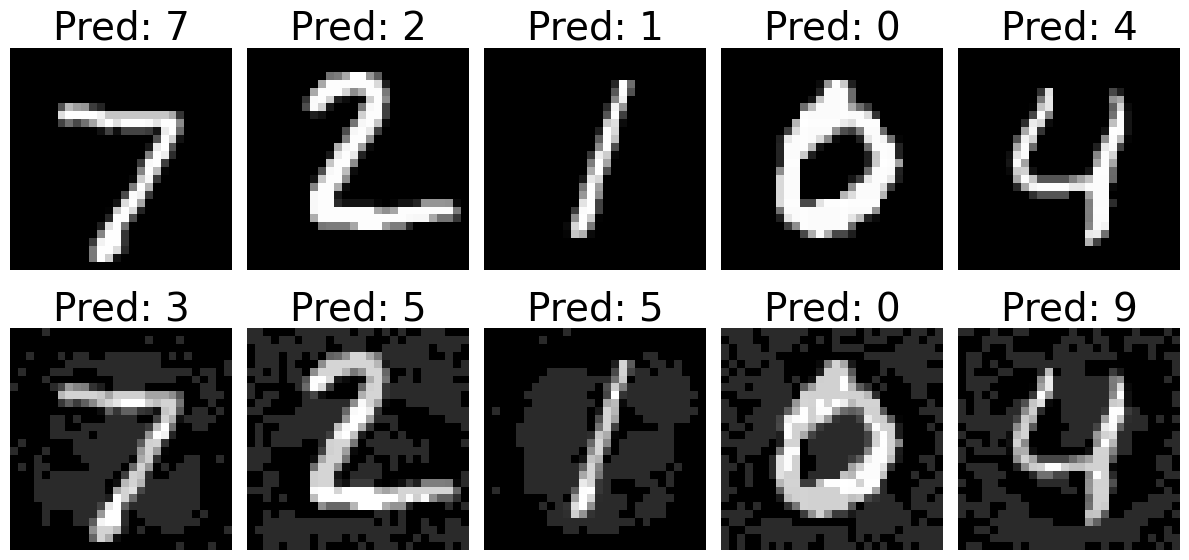

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# MNISTデータセットの読み込みと前処理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# モデルの定義（シンプルなニューラルネットワーク）
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# モデルのインスタンス化
model = SimpleNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 損失関数と最適化手法
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# モデルのトレーニング
def train(model, trainloader, criterion, optimizer, device, epochs=3):
    for epoch in range(epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# モデルを訓練
train(model, trainloader, criterion, optimizer, device)

# FGSMによる敵対的サンプルの生成
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_image = images + epsilon * sign_data_grad
    return perturbed_image

# 敵対的サンプルを生成し、元画像と並べて予測と共に表示する
def display_adversarial_examples(model, testloader, epsilon, device):
    model.eval()
    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)

    # FGSMで敵対的サンプルを生成
    perturbed_images = fgsm_attack(model, images, labels, epsilon)

    # モデルによる予測結果を取得
    original_outputs = model(images)
    perturbed_outputs = model(perturbed_images)

    _, original_preds = torch.max(original_outputs, 1)
    _, perturbed_preds = torch.max(perturbed_outputs, 1)

    # 元画像と敵対的サンプルを表示
    plt.figure(figsize=(12, 6))
    for i in range(5):
        # 元画像を表示
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].cpu().detach().numpy().squeeze(), cmap='gray')
        plt.title(f"Pred: {original_preds[i].item()}", fontsize=28)
        plt.axis('off')

        # 敵対的サンプルを表示
        plt.subplot(2, 5, i+6)
        plt.imshow(perturbed_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
        plt.title(f"Pred: {perturbed_preds[i].item()}", fontsize=28)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# ε（epsilon）を設定して、敵対的サンプルを表示
epsilon = 0.2
display_adversarial_examples(model, testloader, epsilon, device)


# 摂動を変化させた際のモデルの性能評価

Epsilon: 0.0, Adversarial Accuracy: 95.25%
Epsilon: 0.05, Adversarial Accuracy: 83.42%
Epsilon: 0.1, Adversarial Accuracy: 59.59%
Epsilon: 0.15000000000000002, Adversarial Accuracy: 30.24%
Epsilon: 0.2, Adversarial Accuracy: 12.80%
Epsilon: 0.25, Adversarial Accuracy: 4.89%
Epsilon: 0.30000000000000004, Adversarial Accuracy: 1.69%
Epsilon: 0.35000000000000003, Adversarial Accuracy: 0.51%
Epsilon: 0.4, Adversarial Accuracy: 0.16%
Epsilon: 0.45, Adversarial Accuracy: 0.06%
Epsilon: 0.5, Adversarial Accuracy: 0.02%
Epsilon: 0.55, Adversarial Accuracy: 0.00%


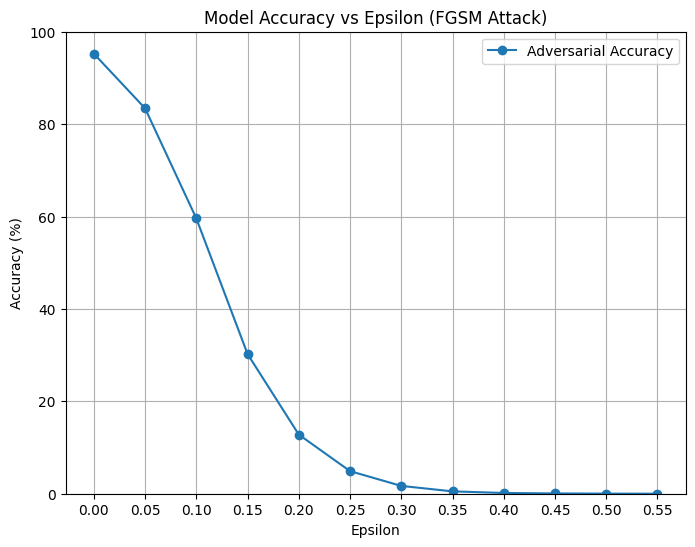

In [8]:
import matplotlib.pyplot as plt

# テスト精度を計算する関数
def test_accuracy(model, testloader, device):
    model.eval()  # 評価モード
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# FGSMによる攻撃を受けた後のテスト精度を計算する関数
def test_accuracy_with_fgsm(model, testloader, epsilon, device):
    model.eval()  # 評価モード
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        # FGSMで敵対的サンプルを生成
        perturbed_images = fgsm_attack(model, images, labels, epsilon)

        # 敵対的サンプルでモデルの精度を計算
        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# epsilonを0.0から0.5まで0.1刻みで設定
epsilon_values = [i * 0.05 for i in range(12)]
adversarial_accuracies = []

# 各epsilonに対して精度を計算
for epsilon in epsilon_values:
    accuracy = test_accuracy_with_fgsm(model, testloader, epsilon, device)
    adversarial_accuracies.append(accuracy)
    print(f"Epsilon: {epsilon}, Adversarial Accuracy: {accuracy:.2f}%")

# プロットを作成
plt.figure(figsize=(8, 6))
plt.plot(epsilon_values, adversarial_accuracies, marker='o', label='Adversarial Accuracy')
plt.title('Model Accuracy vs Epsilon (FGSM Attack)')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.xticks(epsilon_values)
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()


# 摂動に強い学習方法

Training Standard Model...
Epoch 1, Loss: 0.2199
Epoch 2, Loss: 0.0191
Epoch 3, Loss: 0.1076
Training Adversarial Model...
Epoch 1, Loss: 0.7997
Epoch 2, Loss: 0.6374
Epoch 3, Loss: 0.5814

Evaluating Standard Model...
Standard Model Test Accuracy: 96.34%

Evaluating Adversarial Model...
Adversarial Model Test Accuracy: 92.74%

Evaluating Models Under FGSM Attack...
Epsilon: 0.00 | Standard Accuracy: 96.34% | Adversarial Accuracy: 92.74%
Epsilon: 0.05 | Standard Accuracy: 87.36% | Adversarial Accuracy: 87.78%
Epsilon: 0.10 | Standard Accuracy: 64.49% | Adversarial Accuracy: 80.63%
Epsilon: 0.15 | Standard Accuracy: 35.85% | Adversarial Accuracy: 71.05%
Epsilon: 0.20 | Standard Accuracy: 16.23% | Adversarial Accuracy: 58.80%
Epsilon: 0.25 | Standard Accuracy: 6.57% | Adversarial Accuracy: 45.76%
Epsilon: 0.30 | Standard Accuracy: 2.32% | Adversarial Accuracy: 32.59%
Epsilon: 0.35 | Standard Accuracy: 0.79% | Adversarial Accuracy: 21.64%
Epsilon: 0.40 | Standard Accuracy: 0.20% | Adversa

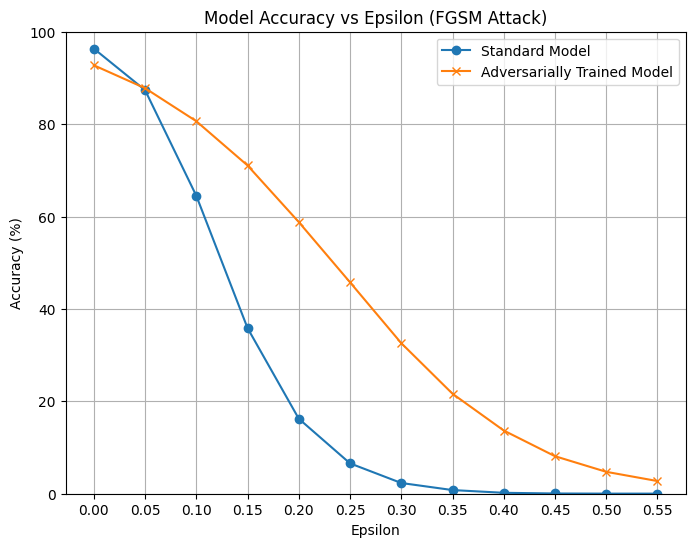

In [15]:
def adversarial_train(model, trainloader, criterion, optimizer, device, epsilon=0, epochs=3):
    for epoch in range(epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            # 敵対的サンプルを生成
            images.requires_grad = True
            outputs = model(images)
            loss = criterion(outputs, labels)
            model.zero_grad()
            loss.backward()
            data_grad = images.grad.data
            adversarial_images = images + epsilon * data_grad.sign()

            # 通常データと敵対的サンプルを交互に使用
            optimizer.zero_grad()
            adv_outputs = model(adversarial_images)
            adv_loss = criterion(adv_outputs, labels)
            adv_loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {adv_loss.item():.4f}")


# モデルの再初期化
model_standard = SimpleNN().to(device)
model_adversarial = SimpleNN().to(device)

# 標準トレーニング（通常学習のみ）
print("Training Standard Model...")
optimizer_standard = optim.Adam(model_standard.parameters(), lr=0.001)
train(model_standard, trainloader, criterion, optimizer_standard, device, epochs=3)

# 敵対的学習
print("Training Adversarial Model...")
optimizer_adversarial = optim.Adam(model_adversarial.parameters(), lr=0.001)
adversarial_train(model_adversarial, trainloader, criterion, optimizer_adversarial, device, epsilon=0.1, epochs=3)

# 標準モデルと敵対的学習済みモデルのテスト精度を比較
print("\nEvaluating Standard Model...")
standard_test_accuracy = test_accuracy(model_standard, testloader, device)
print(f"Standard Model Test Accuracy: {standard_test_accuracy:.2f}%")

print("\nEvaluating Adversarial Model...")
adversarial_test_accuracy = test_accuracy(model_adversarial, testloader, device)
print(f"Adversarial Model Test Accuracy: {adversarial_test_accuracy:.2f}%")

# 各モデルに対するFGSM攻撃後の精度を比較
epsilon_values = [i * 0.05 for i in range(12)]
standard_accuracies = []
adversarial_accuracies = []

print("\nEvaluating Models Under FGSM Attack...")
for epsilon in epsilon_values:
    std_acc = test_accuracy_with_fgsm(model_standard, testloader, epsilon, device)
    adv_acc = test_accuracy_with_fgsm(model_adversarial, testloader, epsilon, device)

    standard_accuracies.append(std_acc)
    adversarial_accuracies.append(adv_acc)

    print(f"Epsilon: {epsilon:.2f} | Standard Accuracy: {std_acc:.2f}% | Adversarial Accuracy: {adv_acc:.2f}%")

# 結果をプロット
plt.figure(figsize=(8, 6))
plt.plot(epsilon_values, standard_accuracies, marker='o', label='Standard Model')
plt.plot(epsilon_values, adversarial_accuracies, marker='x', label='Adversarially Trained Model')
plt.title('Model Accuracy vs Epsilon (FGSM Attack)')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.xticks(epsilon_values)
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()
